# Multi modal model

In [1]:
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import glob
import re
import nltk
import nest_asyncio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from calendar import monthrange
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle
from datetime import datetime, timedelta, date
import pytz
import torch
import torch.nn as nn
import torch.utils.data as td
import sklearn
import pytorch_lightning as pl
from typing import List, Optional

from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('words')
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

import torch

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device: torch.device = torch.device("cpu"),
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading p

# Fetch financial record from 1st January 2015 - 31st May 2021

In [ ]:
start_date ='2015-01-01'
end_date = '2021-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [ ]:
price = price.reset_index()

In [ ]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

# Calculate the percentage change in the Close price
price['Close_pct_change'] = price['Close'].pct_change()

# Create a binary column indicating if the Close price increased (1) or decreased (0)
price['Close_increase'] = (price['Close_pct_change'] > 0).astype(int)

# Fill any NaN values in the new columns with 0 (for the first row)
price['Close_pct_change'].fillna(0, inplace=True)
price['Close_increase'].fillna(0, inplace=True)

# Drop the 'Close_pct_change' column if you no longer need it
price.drop('Close_pct_change', axis=1, inplace=True)


In [ ]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
20,2015-01-21,211.378006,227.787994,211.212006,226.897003,226.897003,29924600,NaN,0,NaN,...,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140,0
21,2015-01-22,227.322006,237.018997,226.434006,233.406006,233.406006,33544600,2.868704,1,0.028687,...,214.882143,229.760211,248.347666,228.736136,251.162887,-22.426751,-22.925908,0.499157,37.948058,1
22,2015-01-23,233.516998,234.845001,225.195999,232.878998,232.878998,24621700,-0.225790,0,-0.002258,...,218.422429,225.650998,244.435617,229.373500,249.808525,-20.435025,-22.427731,1.992706,35.665555,0
23,2015-01-24,232.699997,248.210007,230.022003,247.847000,247.847000,24782500,6.427373,1,0.064274,...,225.363429,223.726070,242.852998,232.215577,249.663227,-17.447650,-21.431715,3.984065,43.263526,1
24,2015-01-25,247.352005,255.074005,243.889999,253.718002,253.718002,33582700,2.368801,1,0.023688,...,231.560429,222.873070,242.354093,235.523642,249.963581,-14.439938,-20.033360,5.593421,46.965307,1


In [ ]:
price.shape

(2536, 23)

### Compute moving average

In [ ]:
# We will compute 7, 14, 21 simple moving average moving average 
# Due to the high volatility nature of crypto currency we chose a 1 day lag

lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)
price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']

In [ ]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [ ]:
price.shape

(2536, 23)

In [ ]:
price.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
2551,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.752840,1,0.007528,...,49613.073103,48354.407924,48720.261347,49445.238442,50481.798187,-1036.559746,-1828.605036,792.045291,52.409775,1
2552,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.332807,0,-0.003328,...,50150.236049,48633.189174,48723.013393,49629.112215,50493.547801,-864.435586,-1635.771146,771.335561,66.874820,0
2553,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-6.025943,0,-0.060259,...,49957.699219,48702.919364,48574.859561,49315.226562,50278.385406,-963.158844,-1501.248686,538.089842,53.368353,0
2554,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,-2.404228,0,-0.024042,...,49645.727679,48527.775670,48381.522135,48873.608773,49994.409519,-1120.800746,-1425.159098,304.358352,40.817228,0
2555,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018,1.579112,1,0.015791,...,49130.525670,48492.968471,48357.998512,48612.765116,49785.795851,-1173.030735,-1374.733425,201.702690,48.104370,1


In [ ]:
price = price.dropna()

In [ ]:
price.isnull().value_counts()

Date   Open   High   Low    Close  Adj Close  Volume  PriceChange  Label  change  log_change  change_label  Close Lagged Price  sma7   sma14  sma21  ema12  ema26  MACD line  Signal line  MACD histogram  rsi    Close_increase
False  False  False  False  False  False      False   False        False  False   False       False         False               False  False  False  False  False  False      False        False           False  False             2516
dtype: int64

In [ ]:
price.describe()

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000,2516.000000,...,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,11334.548734,11645.497021,10994.798455,11351.309967,11351.309967,1.529946e+10,0.288506,0.546900,0.002885,0.002133,...,11294.249936,11225.796988,11159.161586,11245.537827,11105.103976,140.433852,142.618140,-2.184289,55.116535,0.546900
std,15935.928223,16375.924962,15433.816187,15945.777332,15945.777332,2.033206e+10,3.855155,0.497895,0.038552,0.038846,...,15878.450637,15796.278046,15716.505075,15798.927347,15591.150957,950.495301,902.162951,262.164919,18.489007,0.497895
min,210.067993,221.807007,199.567001,210.494995,210.494995,1.060090e+07,-37.169539,0.000000,-0.371695,-0.464730,...,221.382429,223.903716,228.231761,224.278627,227.569340,-5053.274080,-4438.999056,-1694.518206,4.699489,0.000000
25%,704.852020,715.353012,697.435013,704.859741,704.859741,1.101680e+08,-1.211402,0.000000,-0.012114,-0.012188,...,709.455896,688.903465,677.660478,692.613729,660.140483,-39.990101,-38.438908,-25.406462,41.586534,0.000000
50%,6483.655029,6588.800049,6379.869873,6486.775146,6486.775146,5.533791e+09,0.209396,1.000000,0.002094,0.002092,...,6481.779332,6502.181832,6520.244094,6521.792229,6601.517855,8.166580,7.819588,0.747794,55.199686,1.000000
75%,10422.328857,10736.289062,10198.333740,10441.500000,10441.500000,2.552766e+10,1.820711,1.000000,0.018207,0.018043,...,10432.034982,10433.895351,10410.197277,10489.394719,10379.989319,221.234329,228.989894,35.839278,68.231164,1.000000
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,25.247169,1.000000,0.252472,0.225119,...,65510.879464,63983.060826,63016.876488,64182.504548,62406.255181,5273.808690,4517.102703,1305.313389,99.765628,1.000000


In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 40 to 2555
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2516 non-null   datetime64[ns]
 1   Open                2516 non-null   float64       
 2   High                2516 non-null   float64       
 3   Low                 2516 non-null   float64       
 4   Close               2516 non-null   float64       
 5   Adj Close           2516 non-null   float64       
 6   Volume              2516 non-null   int64         
 7   PriceChange         2516 non-null   float64       
 8   Label               2516 non-null   int32         
 9   change              2516 non-null   float64       
 10  log_change          2516 non-null   float64       
 11  change_label        2516 non-null   bool          
 12  Close Lagged Price  2516 non-null   float64       
 13  sma7                2516 non-null   float64    

In [ ]:
price_corr = price.drop(['Date'], axis=1)

In [ ]:
price_corr.corr()

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
Open,1.000000,0.999516,0.999052,0.998789,0.998789,0.728342,-0.022835,-0.042020,-0.022835,-0.024709,...,0.998677,0.995952,0.992920,0.997775,0.993360,0.290538,0.320382,-0.049134,-0.023269,-0.042020
High,0.999516,1.000000,0.999007,0.999477,0.999477,0.731859,-0.006644,-0.031564,-0.006644,-0.009056,...,0.998519,0.995794,0.992742,0.997652,0.993183,0.291391,0.320564,-0.046671,-0.019682,-0.031564
Low,0.999052,0.999007,1.000000,0.999374,0.999374,0.720726,-0.003775,-0.029520,-0.003775,-0.005128,...,0.997706,0.994718,0.991645,0.996782,0.992147,0.293927,0.321258,-0.039861,-0.017516,-0.029520
Close,0.998789,0.999477,0.999374,1.000000,1.000000,0.727267,0.008807,-0.021182,0.008807,0.006787,...,0.997825,0.994839,0.991713,0.996900,0.992189,0.295194,0.322418,-0.039261,-0.014990,-0.021182
Adj Close,0.998789,0.999477,0.999374,1.000000,1.000000,0.727267,0.008807,-0.021182,0.008807,0.006787,...,0.997825,0.994839,0.991713,0.996900,0.992189,0.295194,0.322418,-0.039261,-0.014990,-0.021182
Volume,0.728342,0.731859,0.720726,0.727267,0.727267,1.000000,-0.001250,-0.032995,-0.001250,-0.008563,...,0.729360,0.725706,0.720522,0.726647,0.719259,0.280042,0.312900,-0.061443,0.014363,-0.032995
PriceChange,-0.022835,-0.006644,-0.003775,0.008807,0.008807,-0.001250,1.000000,0.654537,1.000000,0.997836,...,-0.018280,-0.021553,-0.022832,-0.018552,-0.022300,0.057429,0.022897,0.129421,0.277054,0.654537
Label,-0.042020,-0.031564,-0.029520,-0.021182,-0.021182,-0.032995,0.654537,1.000000,0.654537,0.650791,...,-0.037868,-0.039864,-0.040277,-0.038063,-0.039867,0.021262,-0.000677,0.079414,0.231744,1.000000
change,-0.022835,-0.006644,-0.003775,0.008807,0.008807,-0.001250,1.000000,0.654537,1.000000,0.997836,...,-0.018280,-0.021553,-0.022832,-0.018552,-0.022300,0.057429,0.022897,0.129421,0.277054,0.654537
log_change,-0.024709,-0.009056,-0.005128,0.006787,0.006787,-0.008563,0.997836,0.650791,0.997836,1.000000,...,-0.020298,-0.023648,-0.024947,-0.020604,-0.024396,0.057704,0.022698,0.131100,0.278844,0.650791


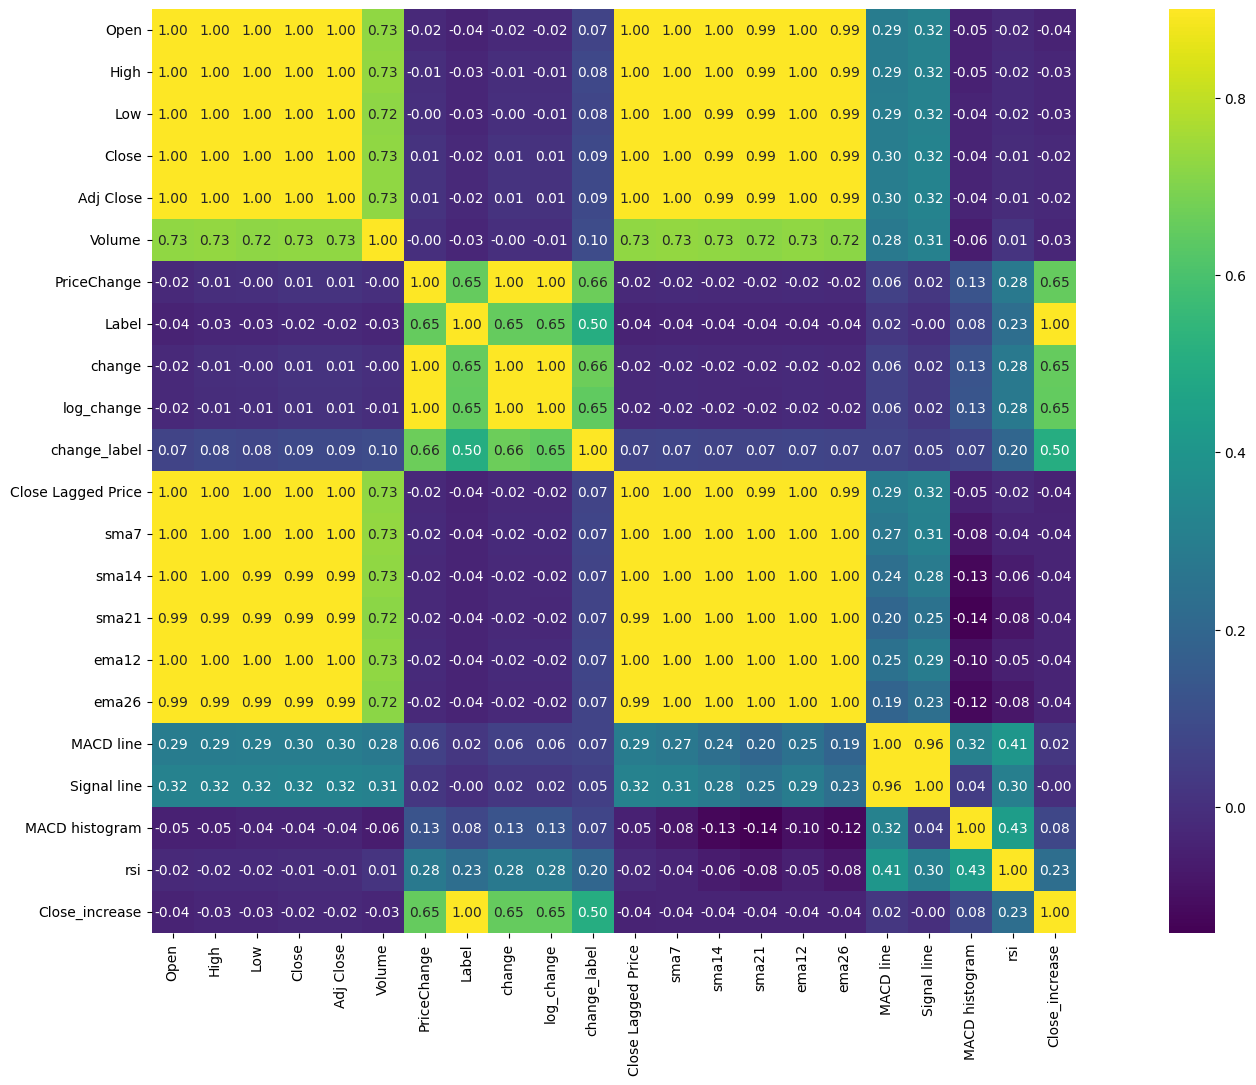

In [ ]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

<Axes: xlabel='Label', ylabel='count'>

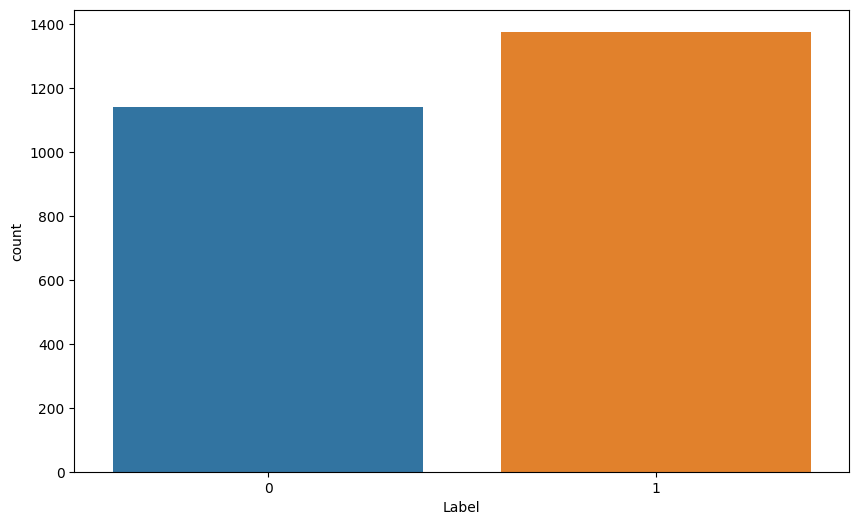

In [ ]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [ ]:
price['Label'].value_counts()

1    1376
0    1140
Name: Label, dtype: int64

In [ ]:
# price.skew()

<Figure size 1200x600 with 0 Axes>

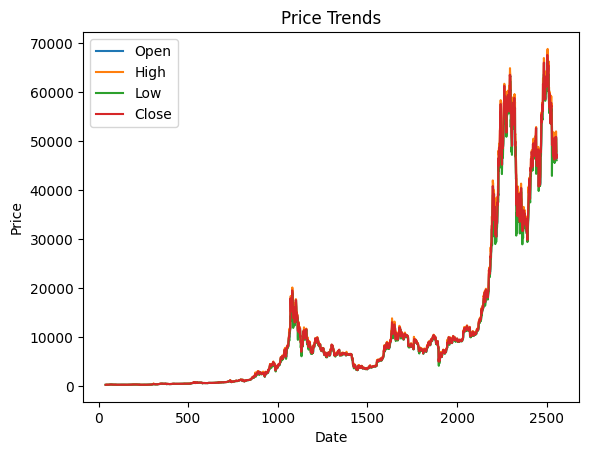

In [ ]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

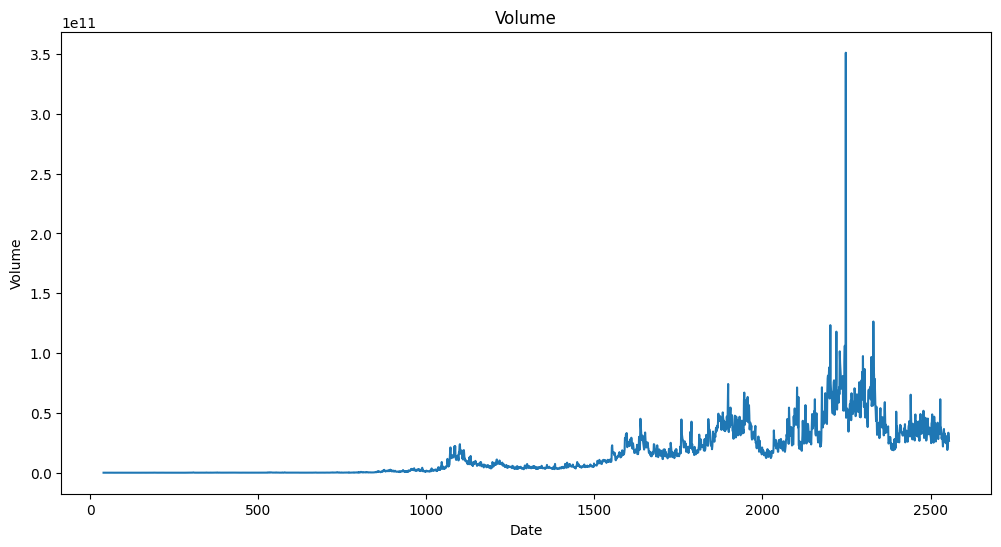

In [ ]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1200x600 with 0 Axes>

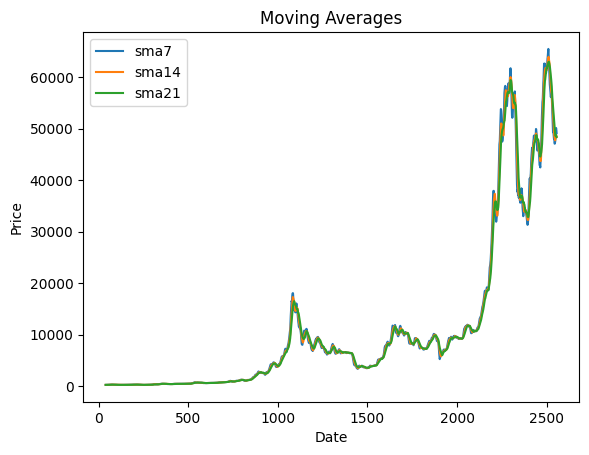

In [ ]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

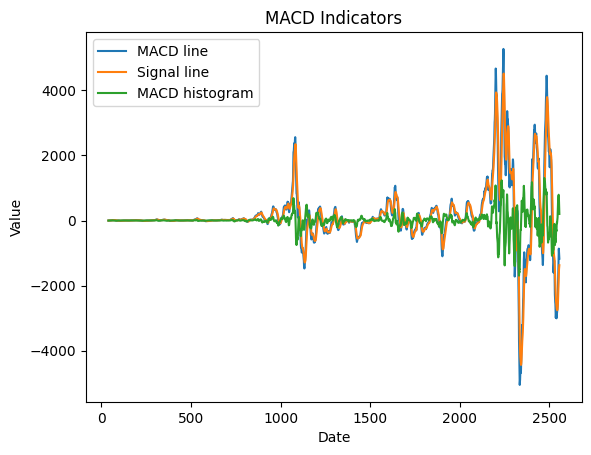

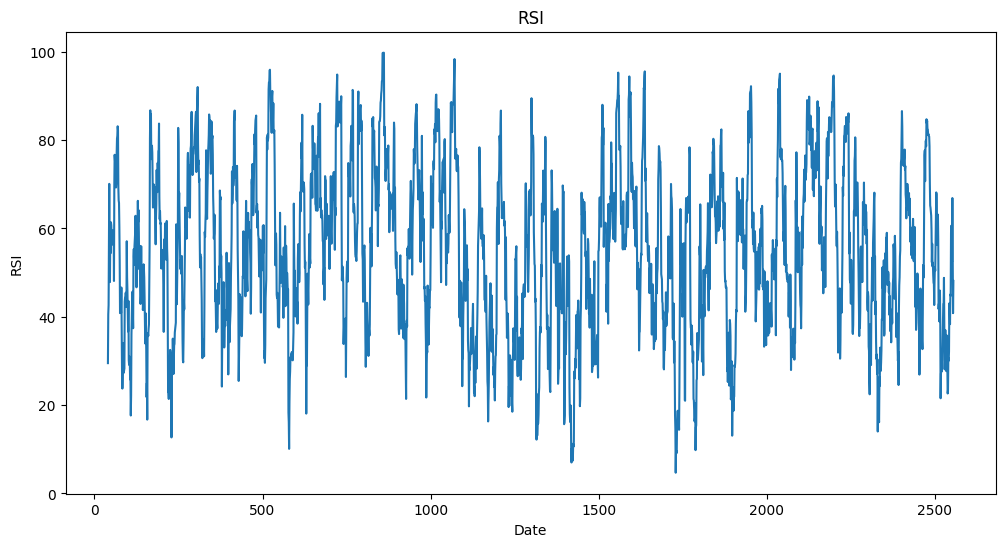

In [ ]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2516 entries, 40 to 2555
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2516 non-null   datetime64[ns]
 1   Open                2516 non-null   float64       
 2   High                2516 non-null   float64       
 3   Low                 2516 non-null   float64       
 4   Close               2516 non-null   float64       
 5   Adj Close           2516 non-null   float64       
 6   Volume              2516 non-null   int64         
 7   PriceChange         2516 non-null   float64       
 8   Label               2516 non-null   int32         
 9   change              2516 non-null   float64       
 10  log_change          2516 non-null   float64       
 11  change_label        2516 non-null   bool          
 12  Close Lagged Price  2516 non-null   float64       
 13  sma7                2516 non-null   float64    

# Process tweets

In [ ]:
price

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
40,2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,-0.123118,0,-0.001231,...,222.477857,225.795072,232.991715,225.745073,228.741668,-2.996595,-1.251966,-1.744630,29.504379,0
41,2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,-0.297494,0,-0.002975,...,221.382429,224.742930,232.624477,224.735830,228.033766,-3.297936,-1.661160,-1.636776,40.502415,0
42,2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,1.176636,1,0.011766,...,222.047145,223.903716,232.070096,224.278627,227.569340,-3.290713,-1.987070,-1.303643,42.631368,1
43,2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,6.161051,1,0.061611,...,223.927288,224.546716,232.191430,225.993761,228.151389,-2.157627,-2.021182,-0.136446,55.215646,1
44,2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,9.299703,1,0.092997,...,228.151147,227.393645,232.642573,230.813339,230.312102,0.501237,-1.516698,2.017935,70.082936,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.752840,1,0.007528,...,49613.073103,48354.407924,48720.261347,49445.238442,50481.798187,-1036.559746,-1828.605036,792.045291,52.409775,1
2552,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.332807,0,-0.003328,...,50150.236049,48633.189174,48723.013393,49629.112215,50493.547801,-864.435586,-1635.771146,771.335561,66.874820,0
2553,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-6.025943,0,-0.060259,...,49957.699219,48702.919364,48574.859561,49315.226562,50278.385406,-963.158844,-1501.248686,538.089842,53.368353,0
2554,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,-2.404228,0,-0.024042,...,49645.727679,48527.775670,48381.522135,48873.608773,49994.409519,-1120.800746,-1425.159098,304.358352,40.817228,0


In [79]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')

In [80]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [81]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [82]:
tweets

,Unnamed: 0,Date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2015-01-01,blocked me thats my achievement still like bit...,False,False,False,False
1,1,2015-01-01,accept here is bitcoin tip via claim it here c...,False,False,False,False
2,2,2015-01-01,btc bitcoin current price btc bitcoin parking ...,False,False,False,False
3,3,2015-01-01,revolution don miss out your bitcoin tip about...,False,False,False,False
4,4,2015-01-01,cap billion based on bitcoin informative my da...,False,False,False,False
...,...,...,...,...,...,...,...
342057,31805,2021-05-31,bitcoin claim free bitcoin bitcoin price sugge...,True,True,False,True
342058,31806,2021-05-31,het roulette het is wat of twitter deal gift s...,True,True,False,True
342059,31807,2021-05-31,longer it stays in this range it will be it go...,True,True,False,True
342060,31808,2021-05-31,en el video para el de media el de en ya para ...,True,True,False,True


In [83]:
tweets = tweets.drop_duplicates(subset=['Date'])

In [84]:
tweets

,Unnamed: 0,Date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2015-01-01,blocked me thats my achievement still like bit...,False,False,False,False
64,64,2015-01-02,bitcoin my brother and have just our first me ...,False,False,False,False
143,143,2015-01-03,bitcoin btc new post cryptocurrency trading ne...,False,False,True,True
228,228,2015-01-04,in the last there were exchange pair yielding ...,False,False,True,True
308,308,2015-01-05,can wait to get my tax refund and buy bitcoin ...,True,True,False,False
...,...,...,...,...,...,...,...
341031,30779,2021-05-27,bitcoin cryptocurrency money the central histo...,False,True,True,True
341235,30983,2021-05-28,what to do when bitcoin price crash bitcoin to...,False,False,True,True
341439,31187,2021-05-29,great project and hope it will achieve lots of...,False,True,True,True
341660,31408,2021-05-30,rager was do that too but like it will take of...,True,True,False,True


In [85]:
tweets = tweets.drop(['label_up5','label_up2','label_down5','label_down2','Unnamed: 0'],axis=1)

In [86]:
tweets

,Date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
64,2015-01-02,bitcoin my brother and have just our first me ...
143,2015-01-03,bitcoin btc new post cryptocurrency trading ne...
228,2015-01-04,in the last there were exchange pair yielding ...
308,2015-01-05,can wait to get my tax refund and buy bitcoin ...
...,...,...
341031,2021-05-27,bitcoin cryptocurrency money the central histo...
341235,2021-05-28,what to do when bitcoin price crash bitcoin to...
341439,2021-05-29,great project and hope it will achieve lots of...
341660,2021-05-30,rager was do that too but like it will take of...


In [87]:
price['Date'] = pd.to_datetime(price['Date'])

In [88]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [89]:
f = tweets.merge(price,how='outer',on=['Date'])

In [90]:
f = f.dropna()

In [91]:
f

,Date,text_split,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
40,2015-02-10,bitcoin btc new post bitcoin price another dip...,220.281998,221.807007,215.332001,219.839005,219.839005,2.111510e+07,-0.123118,0.0,...,222.477857,225.795072,232.991715,225.745073,228.741668,-2.996595,-1.251966,-1.744630,29.504379,0.0
41,2015-02-11,bitcoin at the annual campus party bitcoin boo...,219.731995,223.406006,218.074005,219.184998,219.184998,1.720190e+07,-0.297494,0.0,...,221.382429,224.742930,232.624477,224.735830,228.033766,-3.297936,-1.661160,-1.636776,40.502415,0.0
42,2015-02-12,la el bitcoin that is my my bitcoin bitcoin th...,219.207993,222.199005,217.613998,221.764008,221.764008,1.520620e+07,1.176636,1.0,...,222.047145,223.903716,232.070096,224.278627,227.569340,-3.290713,-1.987070,-1.303643,42.631368,1.0
43,2015-02-13,bitcoin to that make adoption throw of dice le...,221.968994,240.259003,221.261993,235.427002,235.427002,4.274440e+07,6.161051,1.0,...,223.927288,224.546716,232.191430,225.993761,228.151389,-2.157627,-2.021182,-0.136446,55.215646,1.0
44,2015-02-14,bitcoin btc new post overstock top us for bitc...,235.528000,259.808014,235.528000,257.321014,257.321014,4.973250e+07,9.299703,1.0,...,228.151147,227.393645,232.642573,230.813339,230.312102,0.501237,-1.516698,2.017935,70.082936,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2021-05-27,bitcoin cryptocurrency money the central histo...,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,4.321097e+10,-2.181570,0.0,...,37778.753906,40841.439453,45600.178385,40638.535948,45189.957374,-4551.421426,-4252.330512,-299.090914,30.743726,0.0
2243,2021-05-28,what to do when bitcoin price crash bitcoin to...,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,5.520019e+10,-7.126897,0.0,...,37549.170201,39828.373047,44568.807106,39878.392797,44486.820196,-4608.427399,-4323.549889,-284.877509,27.743299,0.0
2244,2021-05-29,great project and hope it will achieve lots of...,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,4.523101e+10,-3.029724,0.0,...,37131.946429,38960.935826,43417.011347,39068.804122,43755.653248,-4686.849127,-4396.209737,-290.639390,29.639910,0.0
2245,2021-05-30,rager was do that too but like it will take of...,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,3.164608e+10,3.068120,1.0,...,37261.595982,38191.083705,42343.002418,38547.161781,43157.318112,-4610.156331,-4438.999056,-171.157275,32.378224,1.0


### Lets work on  the LSTM model

In [110]:
multi_modal = f

In [112]:
multi_modal = multi_modal.drop(['Date', 'text_split'],axis=1)

In [113]:
multi_modal

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
40,220.281998,221.807007,215.332001,219.839005,219.839005,2.111510e+07,-0.123118,0.0,-0.001231,-0.001232,...,222.477857,225.795072,232.991715,225.745073,228.741668,-2.996595,-1.251966,-1.744630,29.504379,0.0
41,219.731995,223.406006,218.074005,219.184998,219.184998,1.720190e+07,-0.297494,0.0,-0.002975,-0.002979,...,221.382429,224.742930,232.624477,224.735830,228.033766,-3.297936,-1.661160,-1.636776,40.502415,0.0
42,219.207993,222.199005,217.613998,221.764008,221.764008,1.520620e+07,1.176636,1.0,0.011766,0.011698,...,222.047145,223.903716,232.070096,224.278627,227.569340,-3.290713,-1.987070,-1.303643,42.631368,1.0
43,221.968994,240.259003,221.261993,235.427002,235.427002,4.274440e+07,6.161051,1.0,0.061611,0.059787,...,223.927288,224.546716,232.191430,225.993761,228.151389,-2.157627,-2.021182,-0.136446,55.215646,1.0
44,235.528000,259.808014,235.528000,257.321014,257.321014,4.973250e+07,9.299703,1.0,0.092997,0.088923,...,228.151147,227.393645,232.642573,230.813339,230.312102,0.501237,-1.516698,2.017935,70.082936,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,4.321097e+10,-2.181570,0.0,-0.021816,-0.022057,...,37778.753906,40841.439453,45600.178385,40638.535948,45189.957374,-4551.421426,-4252.330512,-299.090914,30.743726,0.0
2243,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,5.520019e+10,-7.126897,0.0,-0.071269,-0.073936,...,37549.170201,39828.373047,44568.807106,39878.392797,44486.820196,-4608.427399,-4323.549889,-284.877509,27.743299,0.0
2244,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,4.523101e+10,-3.029724,0.0,-0.030297,-0.030766,...,37131.946429,38960.935826,43417.011347,39068.804122,43755.653248,-4686.849127,-4396.209737,-290.639390,29.639910,0.0
2245,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,3.164608e+10,3.068120,1.0,0.030681,0.030220,...,37261.595982,38191.083705,42343.002418,38547.161781,43157.318112,-4610.156331,-4438.999056,-171.157275,32.378224,1.0


In [114]:
df = multi_modal

In [108]:
prediction_period = 20

In [115]:
y_hats = []

for i in reversed(range(prediction_period)):
    print(i)

    h = i + 1
    window_index = (len(df) - h)


    y_win = df[: window_index].tail(10)

    y_hats.append(y_win.mean())

19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [116]:
df.tail(prediction_period)

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,...,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi,Close_increase
2227,56714.531250,57939.363281,49150.535156,49150.535156,49150.535156,7.521540e+10,-13.321745,0.0,-0.133217,-0.142967,...,56071.988281,56159.012277,54857.942522,55472.359353,55877.563715,-405.204362,-103.575847,-301.628515,40.556745,0.0
2228,49735.433594,51330.843750,46980.019531,49716.191406,49716.191406,9.672115e+10,1.150865,1.0,0.011509,0.011443,...,55117.656250,55884.803850,54760.510045,54586.795054,55421.165767,-834.370713,-249.734820,-584.635893,43.457778,1.0
2229,49682.980469,51438.117188,48868.578125,49880.535156,49880.535156,5.573750e+10,0.330564,1.0,0.003306,0.003300,...,54049.675223,55322.686663,54702.742560,53862.755069,55010.748684,-1147.993615,-429.386579,-718.607036,34.452780,1.0
2230,49855.496094,50639.664062,46664.140625,46760.187500,46760.187500,5.916105e+10,-6.255642,0.0,-0.062556,-0.064599,...,52329.162388,54532.125000,54546.043527,52770.052366,54399.596004,-1629.543638,-669.417991,-960.125647,30.480860,0.0
2231,46716.636719,49720.042969,43963.351562,46456.058594,46456.058594,6.404787e+10,-0.650401,0.0,-0.006504,-0.006525,...,50646.839844,53805.337891,54424.700893,51798.668709,53811.185825,-2012.517116,-938.037816,-1074.479300,31.471980,0.0
2232,46415.898438,46623.558594,42207.289062,43537.511719,43537.511719,7.490364e+10,-6.282382,0.0,-0.062824,-0.064884,...,48886.513393,52829.424944,53925.451265,50527.721480,53050.172929,-2522.451449,-1254.920543,-1267.530906,27.081867,0.0
2233,43488.058594,45812.457031,42367.832031,42909.402344,42909.402344,5.618737e+10,-1.442686,0.0,-0.014427,-0.014532,...,46915.774554,52084.843750,53348.131510,49355.672382,52299.004737,-2943.332355,-1592.602905,-1350.729450,30.383008,0.0
2234,42944.976562,43546.117188,30681.496094,37002.441406,37002.441406,1.263581e+11,-13.766123,0.0,-0.137661,-0.148107,...,45180.332589,50626.160435,52499.452381,47455.175309,51165.925972,-3710.750663,-2016.232457,-1694.518206,14.028355,0.0
2235,36753.667969,42462.984375,35050.617188,40782.738281,40782.738281,8.828194e+10,10.216344,1.0,0.102163,0.097275,...,43904.125000,49510.890625,51891.244234,46428.646535,50396.800958,-3968.154423,-2406.616850,-1561.537573,24.928460,1.0
2236,40596.949219,42172.171875,33616.453125,37304.691406,37304.691406,8.205162e+10,-8.528233,0.0,-0.085282,-0.089140,...,42107.575893,48078.625558,50917.649740,45024.961131,49427.015065,-4402.053934,-2805.704267,-1596.349667,20.211332,0.0


In [118]:
from sklearn.metrics import mean_absolute_error

In [119]:
mean_absolute_error(df.tail(prediction_period), y_hats)

827791429.9301518

In [134]:
column_indices = {name: i for i, name in enumerate(df.columns)}

column_indices

{'Open': 0,
 'High': 1,
 'Low': 2,
 'Close': 3,
 'Adj Close': 4,
 'Volume': 5,
 'PriceChange': 6,
 'Label': 7,
 'change': 8,
 'log_change': 9,
 'change_label': 10,
 'Close Lagged Price': 11,
 'sma7': 12,
 'sma14': 13,
 'sma21': 14,
 'ema12': 15,
 'ema26': 16,
 'MACD line': 17,
 'Signal line': 18,
 'MACD histogram': 19,
 'rsi': 20,
 'Close_increase': 21}

In [120]:
n = len(df)
n

2207

In [121]:
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [122]:
num_features = df.shape[1]

num_features

22

In [123]:
train_mean = train_df.mean()
train_std = train_df.std()

In [135]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Windows Generator

In [136]:
class WindowsGenerator():
    def __init__(self, input_width, label_width,shift, train_df,val_df,test_df,label_columns = None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        self.column_indices = {name: i for i,name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_windows_size = input_width + shift

        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_windows_size)[self.input_slice]

        self.label_start = self.total_windows_size - self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.labe_indices = np.arange(self.total_windows_size)[self.labels_slice]

    def split_window(self,features):
        inputs = features[:, self.input_slice,:]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns],axis=1)
        
        inputs.set_shape([None, self.input_width,None])
        labels.set_shape([None, self.label_width,None])

        return inputs, labels

    
    def make_dataset(self,data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,targets=None,sequence_length=self.total_windows_size,sequence_stride=1,shuffle=False,batch_size=32)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)


In [141]:
single_step_window = WindowsGenerator(input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=['Close_increase'])

### Build a Baseline Model

In [127]:

import tensorflow as tf

In [137]:
class Baseline(tf.keras.Model):
    def __init__(self,label_index = None):
        super().__init__()
        self.label_index = label_index

    def call(self,inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:,:, self.label_index]
        return result[:,:, tf.newaxis]

In [138]:
def compile_and_fit(model,window, epochs=20, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

    model.fit(window.train,epochs = epochs, callbacks=[early_stopping])

In [142]:
baseline = Baseline(label_index=column_indices['Close_increase']) 

In [ ]:
compile_and_fit(baseline, single_step_window)

In [144]:
val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

14/14 [==============================] - 0s 1ms/step - loss: 9.1210 - mean_absolute_error: 2.2465


In [145]:
val_performance

{'Baseline': [9.121048927307129, 2.2464566230773926]}

### Create linear model

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM,Conv1D, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU

In [152]:
linear = Sequential()
linear.add(Dense(units=1))

In [ ]:
compile_and_fit(linear, single_step_window)

In [ ]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
val_performance

### Dense Model

In [155]:
dense = Sequential()
dense.add(Dense(units=64, activation='relu'))
dense.add(Dense(units=64, activation='relu'))
dense.add(Dense(units=1))

In [ ]:
compile_and_fit(dense, single_step_window)

In [157]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
val_performance

14/14 [==============================] - 0s 2ms/step - loss: 4.2236 - mean_absolute_error: 2.0320


{'Baseline': [9.121048927307129, 2.2464566230773926],
 'Linear': [6.236713886260986, 2.093287467956543],
 'Dense': [4.223604202270508, 2.032038927078247]}

### CNN

In [165]:
CONV_WIDTH = 3

conv_window = WindowsGenerator(input_width=CONV_WIDTH,label_width=1,shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=['Close_increase'])

In [196]:
conv_model = Sequential()
conv_model.add(Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'))
conv_model.add(Dense(units=32, activation='relu'))
conv_model.add(Dense(units=1))

In [197]:
compile_and_fit(conv_model,conv_window)

Epoch 1/20
49/49 [==============================] - 2s 4ms/step - loss: 5.8137 - mean_absolute_error: 2.1104
Epoch 2/20
49/49 [==============================] - 0s 6ms/step - loss: 4.3231 - mean_absolute_error: 1.9650
Epoch 3/20
49/49 [==============================] - 0s 5ms/step - loss: 4.1879 - mean_absolute_error: 1.9556
Epoch 4/20
49/49 [==============================] - 0s 4ms/step - loss: 4.1295 - mean_absolute_error: 1.9457
Epoch 5/20
49/49 [==============================] - 0s 3ms/step - loss: 4.1032 - mean_absolute_error: 1.9397
Epoch 6/20
49/49 [==============================] - 0s 4ms/step - loss: 4.0809 - mean_absolute_error: 1.9351
Epoch 7/20
49/49 [==============================] - 0s 4ms/step - loss: 4.0592 - mean_absolute_error: 1.9319
Epoch 8/20
49/49 [==============================] - 0s 3ms/step - loss: 4.0415 - mean_absolute_error: 1.9278
Epoch 9/20
49/49 [==============================] - 0s 4ms/step - loss: 4.0296 - mean_absolute_error: 1.9246
Epoch 10/20
49/49 [

In [168]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
val_performance


14/14 [==============================] - 0s 2ms/step - loss: 4.3088 - mean_absolute_error: 2.0102


{'Baseline': [9.121048927307129, 2.2464566230773926],
 'Linear': [6.236713886260986, 2.093287467956543],
 'Dense': [4.223604202270508, 2.032038927078247],
 'Conv': [4.308793067932129, 2.0101985931396484]}

### RNN and LSTM

In [169]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dense(units=1))

In [175]:
wide_window = WindowsGenerator(input_width=24, label_width=24, shift=1,train_df=train_df,val_df=val_df,test_df=test_df,label_columns=['Close_increase'])

In [ ]:
compile_and_fit(lstm_model, wide_window)

In [ ]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
val_performance

In [ ]:
model.summary()

### Multiple output

In [176]:
single_step_window_multiple = WindowsGenerator(input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df,test_df=test_df)

In [177]:
wide_step_window_multiple = WindowsGenerator(input_width=1, label_width=1, shift=1,train_df=train_df,val_df=val_df,test_df=test_df)

In [148]:
from sklearn.model_selection import train_test_split

In [93]:
sentence = f['text_split'].values
label = f['change_label'].map({True: 1, False: 0})

In [94]:
label

40      0
41      0
42      0
43      1
44      1
       ..
2242    0
2243    0
2244    0
2245    1
2246    1
Name: change_label, Length: 2207, dtype: int64

In [95]:
sentence_train,sentence_test, label_train,label_test = train_test_split(sentence, label,test_size=0.25, random_state=1000)

In [96]:
from keras.preprocessing.text import Tokenizer

tokenizer  = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence_train)


In [97]:
xcnn_train = tokenizer.texts_to_sequences(sentence_train)
xcnn_test = tokenizer.texts_to_sequences(sentence_test)
vocab_size = len(tokenizer.word_index) + 1

In [98]:
%pip install keras_preprocessing


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D

In [100]:
maxlen = 200
xcnn_train = pad_sequences(xcnn_train,padding='post', maxlen=maxlen)

xcnn_test = pad_sequences(xcnn_test, padding='post',maxlen=maxlen)

In [101]:
embedding_dim = 200
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length=maxlen))
model.add(Conv1D(128,5,activation='relu'))
model.add(MaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          1925000   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 128)          0         
 )                                                               
                                                                 
 dense (Dense)               (None, 98, 10)            1290      
                                                                 
 dense_1 (Dense)             (None, 98, 1)             11        
                                                                 
Total params: 2,054,429
Trainable params: 2,054,429
Non-trainable params: 0
______________________________________________

In [102]:
model.fit(xcnn_train, label_train, epochs=2, verbose=True, validation_data=(xcnn_test,label_test),batch_size=10)

Epoch 1/2
166/166 [==============================] - 7s 34ms/step - loss: 0.5535 - accuracy: 0.7708 - val_loss: 0.5615 - val_accuracy: 0.7536
Epoch 2/2
166/166 [==============================] - 5s 32ms/step - loss: 0.5273 - accuracy: 0.7716 - val_loss: 0.5758 - val_accuracy: 0.7536


In [103]:
print(vocab_size)
print(sentence_train[1])
print(xcnn_train[1])

9625
bitcoin true currency of the people bitcoin finance freedom evolution earn bitcoin advertising bitcoin the latest bitcoin price index is bitcoin happy birthday bitcoin luke because it technically impossible not just any bu node that this block got itself by all sane that it the re are stupid btc the index score for is bitcoin bitcoin trading alert volatility dramatically un video de para bitcoin bitcoin dont miss this reg now legal block chain do not miss this via bitcoin tool used to pay ransom as hotel hit by crime now bitcoin pass on to any you might know trump donate serious question when you place do you deposit with your visa or use bitcoin credit china inks million deal with bitcoin firm development team version of leading bitcoin mining btc crypto bitcoin re will bitcoin overcome bitcoin end trump now bitcoin con bitcoin si te the tribe live bitcoin bitcoin is nu gratis door te via china research institute to study bitcoin and test bitcoin trading alert volatility dramatic

In [104]:
tokenizer

In [ ]:
len(tweets['text_split'][3])

In [ ]:
# tweets = tweets.drop(columns=['date', 'label_up5','label_up2','label_down5','label_down2'])

In [ ]:
tweets.shape

(2247, 2)

In [ ]:
tweets

,Date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
1,2015-01-02,bitcoin my brother and have just our first me ...
2,2015-01-03,bitcoin btc new post cryptocurrency trading ne...
3,2015-01-04,in the last there were exchange pair yielding ...
4,2015-01-05,can wait to get my tax refund and buy bitcoin ...
...,...,...
2242,2021-05-27,bitcoin cryptocurrency money the central histo...
2243,2021-05-28,what to do when bitcoin price crash bitcoin to...
2244,2021-05-29,great project and hope it will achieve lots of...
2245,2021-05-30,rager was do that too but like it will take of...


In [ ]:

# tweets['Date']=tweets.Date.apply (lambda x : str(x)[:10])

In [ ]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [ ]:
price['Date'] = pd.to_datetime(price['Date'])

In [ ]:
price_tweets = tweets.merge(price, how='outer', on=['Date'])

In [ ]:
price_tweets.head()

,Date,text_split,Open,High,Low,Close,Adj Close,Volume,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,change,log_change,change_label,rsi
0,2015-01-01,blocked me thats my achievement still like bit...,320.434998,320.434998,314.002991,314.248993,314.248993,8036550.0,NaN,NaN,NaN,319.278532,319.752697,-0.474165,-0.094833,-0.379332,-0.018564,-0.018738,False,NaN
1,2015-01-02,bitcoin my brother and have just our first me ...,314.079010,315.838989,313.565002,315.032013,315.032013,7860650.0,NaN,NaN,NaN,318.625221,319.403017,-0.777796,-0.231426,-0.546370,0.002492,0.002489,True,NaN
2,2015-01-03,bitcoin btc new post cryptocurrency trading ne...,314.846008,315.149994,281.082001,281.082001,281.082001,33054400.0,NaN,NaN,NaN,312.849341,316.564423,-3.715082,-0.928157,-2.786925,-0.107767,-0.114028,False,NaN
3,2015-01-04,in the last there were exchange pair yielding ...,281.145996,287.230011,257.612000,264.195007,264.195007,55629100.0,NaN,NaN,NaN,305.364059,312.685207,-7.321148,-2.206755,-5.114393,-0.060079,-0.061959,False,NaN
4,2015-01-05,can wait to get my tax refund and buy bitcoin ...,265.084015,278.341003,265.084015,274.473999,274.473999,43962800.0,NaN,NaN,NaN,300.611742,309.854747,-9.243005,-3.614005,-5.629000,0.038907,0.038169,True,NaN


In [ ]:
price_tweets.shape

(2344, 20)

## Word embeddings

#### Now that we have our dataset, let's get the word embedding for the news articles

In [243]:
# %pip install transformers torch
# %pip install torchtext
# %pip install torchtext.legacy
# %pip install torchtext==0.8.1
%pip install -U torch==1.8.0 torchtext==0.9.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.8.0

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# import torch
# # from torchtext import data
# import numpy as np
# import torchtext
# import torch
# from torchtext.legacy import data
# from torchtext.legacy import datasets
# # import torch
# # import torchtext
# from torchtext.legacy.data import Iterator
# # from torchtext.data import Field, BucketIterator, TabularDataset

# SEED = 1234

# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

import torchtext
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

In [236]:
import numpy as np

import torch
import torchtext
# from torchtext.legacy import data
# from torchtext.data import Field, BucketIterator, TabularDataset

In [ ]:
from transformers import AutoModel, AutoTokenizer

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
def processEmbeddings(text):
    tokens = tokenizer.tokenize(text)

    # Set the maximum segment length and overlap
    max_segment_length = 200
    overlap = 50

    # Initialize lists to store embeddings and segment tokens
    embeddings_list = []
    segment_tokens_list = []

    # Slide a window over the tokens and process each segment
    for start in range(0, len(tokens), max_segment_length - overlap):
        end = start + max_segment_length
        segment_tokens = tokens[start:end]

        # Convert segment tokens back to text and encode
        segment_text = tokenizer.convert_tokens_to_string(segment_tokens)
        inputs = tokenizer(segment_text, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]

        embeddings_list.append(embeddings)
        segment_tokens_list.append(segment_tokens)

    # Combine embeddings and segment tokens for the entire text
    all_embeddings = torch.cat(embeddings_list, dim=0)
    # all_segment_tokens = sum(segment_tokens_list, [])
    
    return all_embeddings


In [ ]:
f['text_embedding'] = f['text_split'].apply(processEmbeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
f['text_embedding']

In [ ]:
# Replace True with 1 and False with 0
price_tweets['change_label'] = price_tweets['change_label'].map({True: 1, False: 0})

C:\Users\HP\AppData\Local\Temp\ipykernel_15080\3128454574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_tweets['change_label'] = price_tweets['change_label'].map({True: 1, False: 0})


In [ ]:
price_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 19 to 2245
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2227 non-null   datetime64[ns]
 1   text_split       2227 non-null   object        
 2   Open             2227 non-null   float64       
 3   High             2227 non-null   float64       
 4   Low              2227 non-null   float64       
 5   Close            2227 non-null   float64       
 6   Adj Close        2227 non-null   float64       
 7   Volume           2227 non-null   float64       
 8   sma7             2227 non-null   float64       
 9   sma14            2227 non-null   float64       
 10  sma21            2227 non-null   float64       
 11  ema12            2227 non-null   float64       
 12  ema26            2227 non-null   float64       
 13  MACD line        2227 non-null   float64       
 14  Signal line      2227 non-null   float6

### Build the architecture

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D

In [ ]:
features = price_tweets[['text_embeddings']]
target = price_tweets['change_label']

In [ ]:
target

19      0
20      1
21      1
22      0
23      1
       ..
2241    1
2242    0
2243    0
2244    0
2245    1
Name: change_label, Length: 2227, dtype: int64

In [ ]:
# features = price_tweets.drop(['change_label', 'Date'], axis=1)  # Adjust columns as needed
# target = price_tweets['change_label']

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1726 entries, 383 to 2108
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1726 non-null   float64
 1   Open                1726 non-null   float64
 2   High                1726 non-null   float64
 3   Low                 1726 non-null   float64
 4   Close               1726 non-null   float64
 5   Adj Close           1726 non-null   float64
 6   Volume              1726 non-null   float64
 7   Close Lagged Price  1726 non-null   float64
 8   sma7                1726 non-null   float64
 9   sma14               1726 non-null   float64
 10  sma21               1726 non-null   float64
 11  ema12               1726 non-null   float64
 12  ema26               1726 non-null   float64
 13  MACD line           1726 non-null   float64
 14  Signal line         1726 non-null   float64
 15  MACD histogram      1726 non-null   float64
 16  chan

In [ ]:
# Split the data into training, validation, and testing sets
# First, split into training and temp sets (80% training, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)

# Then, split the temp set into validation and testing sets (50% validation, 50% testing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Normalize numerical features for each set
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.drop('text_embeddings', axis=1))
# X_val_scaled = scaler.transform(X_val.drop('text_embeddings', axis=1))
# X_test_scaled = scaler.transform(X_test.drop('text_embeddings', axis=1))


### Build CNN model

In [ ]:
def cnn(embedding_dim):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(embedding_dim, 1)))
    model.add(MaxPooling1D(2))
    # model.add(Conv1D(128, 3, activation='relu'))
    # model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Conv1D(filters=16, kernel_size=(3,3), activation="relu",input_shape=(embedding_dim,)))

    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
    
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
    
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Flatten())

    # model.add(Dense(64,activation='relu'))

    # model.add(Dense(1,activation='sigmoid'))

    # model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [ ]:
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]

In [ ]:
model = cnn(embedding_dim)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 766, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 383, 64)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24512)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               3137664   
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,138,049
Trainable params: 3,138,049
Non-trainable params: 0
____________________________________________

In [ ]:
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]

In [ ]:
# Build the LSTM model for text embeddings
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]
text_input = Input(shape=(embedding_dim,), name='text_input')
text_lstm = Dense(64, activation='relu')(text_input)

In [ ]:
# Build the LSTM model for numerical features
num_features_input = Input(shape=(X_train_scaled.shape[1],), name='num_features_input')
num_lstm = Dense(64, activation='relu')(num_features_input)

In [ ]:
# Combine the outputs of both LSTM models
concatenated = concatenate([text_lstm, num_lstm])

In [ ]:
# Build the final prediction layer
output = Dense(1, activation='sigmoid')(concatenated)

In [ ]:
# Create the multi-modal model
model = Model(inputs=[text_input, num_features_input], outputs=output)

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
data = features['text_embeddings']

In [ ]:
target.info()

<class 'pandas.core.series.Series'>
Int64Index: 2227 entries, 19 to 2245
Series name: change_label
Non-Null Count  Dtype
--------------  -----
2227 non-null   int64
dtypes: int64(1)
memory usage: 34.8 KB


In [ ]:
import tensorflow as tf


In [ ]:
model.fit(data, np.array(target),validation_split=0.4, epochs=3)

In [ ]:
# Train the model
model.fit([np.array(X_train['text_embeddings']), X_train_scaled], y_train,
          epochs=10, batch_size=32, validation_data=([np.array(X_test['text_embeddings'].tolist()), X_test], y_test))


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([np.array(X_test['text_embeddings'].tolist()), X_test_scaled], y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

6/6 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9653
Loss: 0.1412552446126938, Accuracy: 0.9653179049491882
